# Imports

In [1]:
import t3f
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from environments import Snake
from methods import ReplayMemory

# Experiments

In [3]:
def tf_repeat(x, num):
    u = tf.reshape(x, (-1, 1))
    ones = tf.ones(1, dtype=tf.int32)
    u = tf.tile(u, tf.concat([ones, num], axis=0))
    u = tf.reshape(u, (-1, 1))
    return u

In [4]:
class QQTT:
    
    def __init__(self, num_actions, num_colors=4, state_shape=[8, 8, 1],
                 tt_rank=8, optimizer=tf.train.AdamOptimizer(2.5e-4), 
                 dtype=tf.float32, scope="qqtt_network", reuse=False):
        
        input_shape = np.prod(state_shape) * [num_colors,] + [num_actions,]
        
        with tf.variable_scope(scope, reuse=reuse):
            
            # random initialization of Q-tensor
            q0init = t3f.random_tensor(shape=input_shape, tt_rank=tt_rank, stddev=1e-3)
            q0init = t3f.cast(q0init, dtype=dtype)
            q0 = t3f.get_variable('Q', initializer=q0init)
        
            self.input_states = tf.placeholder(dtype=tf.int32, shape=[None]+state_shape)
            self.input_actions = tf.placeholder(dtype=tf.int32, shape=[None])
            self.input_targets = tf.placeholder(dtype=dtype, shape=[None])

            reshaped_s = tf.reshape(self.input_states, (-1, np.prod(state_shape)))
            reshaped_a = tf.reshape(self.input_actions, (-1, 1))
            input_s_and_a = tf.concat([reshaped_s, reshaped_a], axis=1) 
            self.q_selected = t3f.gather_nd(q0, input_s_and_a, dtype=dtype)

            reshaped_s_ = tf.reshape(self.input_states, [-1]+state_shape)
            
            # some shitty code
            s_a_idx = tf.concat(num_actions * [reshaped_s], axis=0) 
            actions_range = tf.range(start=0, limit=num_actions)
            a_idx = tf_repeat(actions_range, tf.shape(self.input_states)[0:1])
            s_a_idx = tf.concat([s_a_idx, a_idx], axis=1)
            vals = t3f.gather_nd(q0, s_a_idx, dtype=dtype)
            q_values = tf.transpose(tf.reshape(vals, shape=(num_actions, -1)))
            # shitty code ends here
            
            self.q_argmax = tf.argmax(q_values, axis=1)
            self.q_max = tf.reduce_max(q_values, axis=1)
            
            self.loss = tf.losses.huber_loss(self.q_selected, self.input_targets)
            self.update_model = optimizer.minimize(self.loss)
        
    def update(self, sess, states, actions, targets):
        feed_dict = {self.input_states:states,
                     self.input_actions:actions,
                     self.input_targets:targets}
        sess.run(self.update_model, feed_dict)
        
    def get_q_action_values(self, sess, states, actions):
        feed_dict = {self.input_states:states,
                     self.input_actions:actions}
        return sess.run(self.q_selected, feed_dict=feed_dict)
        
    def get_q_argmax(self, sess, states):
        feed_dict = {self.input_states:states}
        return sess.run(self.q_argmax, feed_dict=feed_dict)
    
    def get_q_max(self, sess, states):
        feed_dict = {self.input_states:states}
        return sess.run(self.q_max, feed_dict=feed_dict)

In [5]:
batch_size = 64

replay_memory_size=50000
replay_start_size=10000
init_eps=1
final_eps=0.02
annealing_steps=100000
gamma=0.99
max_episode_length = 400
num_episodes = 1000000

In [6]:
train_env = Snake(grid_size=(4, 4))

In [7]:
s = train_env.reset()

In [8]:
qqtt_agent = QQTT(3, state_shape=[4, 4, 1], scope="qqtt", reuse=False)

In [9]:
rep_buffer = ReplayMemory(replay_memory_size)
frame_count = 0
while (frame_count < replay_start_size):
    s = train_env.reset()
    for time_step in range(max_episode_length):
        a = np.random.randint(3)
        s_, r, end = train_env.step(a)
        rep_buffer.push(s, a, r, s_, end)
        s = s_
        frame_count += 1
        if end:
            break

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = str(2)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [11]:
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [12]:
eps = init_eps
eps_drop = (init_eps - final_eps) / annealing_steps

In [13]:
train_rewards = []
frame_counts = []
frame_count = 0
for i in range(num_episodes):
    
    #episode_hash = {}
    #cycle_count = 0
    
    s = train_env.reset()
    R = 0
    for time_step in range(max_episode_length):
        frame_count += 1
        
        #key = hash(s.tostring())
        
        #if key in episode_hash:
        #    cycle_count += 1
        #else:
        #    episode_hash[key] = 1

        if np.random.rand(1) < eps:
            a = np.random.randint(3)
        else:
            a = qqtt_agent.get_q_argmax(sess, [s])[0]
            
        if eps > final_eps:
            eps -= eps_drop
        
        s_, r, done = train_env.step(a)
        R += r
        #if r == 0: r = -0.01
        
        #if cycle_count > 1:
        #    rep_buffer.push(s, a, -1, s_, end)
        #    break
            
        rep_buffer.push(s, a, r, s_, end)
        s = s_

        if time_step % 4 == 0:
            batch = rep_buffer.get_batch(batch_size)
            
            q_ = qqtt_agent.get_q_max(sess, batch.s_)
            targets = batch.r + gamma * q_ * batch.end
            
            qqtt_agent.update(sess, batch.s, batch.a, targets)
            
        if done: break
    train_rewards.append(R) 
    frame_counts.append(frame_count)
    if i % 500 == 0:
        avg_reward = np.mean(train_rewards[-500:])
        max_reward = np.max(train_rewards[-500:])
        print("Train info:", frame_count, avg_reward, max_reward, eps) 
    if i % 2000 == 0:
        np.savez("snake_models/qqtt4/learning_curve.npz", r=train_rewards, f=frame_counts)

Train info: 5 -1.0 -1 0.9999510000000003
Train info: 1738 -0.81 2 0.9829676000000891
Train info: 3410 -0.826 1 0.9665820000001748
Train info: 5151 -0.782 2 0.949520200000264
Train info: 6980 -0.806 3 0.9315960000003578
Train info: 8821 -0.766 2 0.9135542000004522
Train info: 10635 -0.774 2 0.8957770000005452
Train info: 12476 -0.746 2 0.8777352000006395
Train info: 14384 -0.764 2 0.8590368000007373
Train info: 16277 -0.768 1 0.8404854000008344
Train info: 18331 -0.722 2 0.8203562000009397
Train info: 20371 -0.708 2 0.8003642000010442
Train info: 22438 -0.68 3 0.7801076000011502
Train info: 24563 -0.676 3 0.7592826000012591
Train info: 26710 -0.65 3 0.7382420000013692
Train info: 29165 -0.602 2 0.714183000001495
Train info: 31477 -0.64 3 0.6915254000016136
Train info: 33950 -0.57 2 0.6672900000017403
Train info: 36456 -0.616 2 0.6427312000018688
Train info: 39100 -0.576 3 0.6168200000020043
Train info: 41681 -0.502 2 0.5915262000021366
Train info: 44301 -0.52 4 0.5658502000022709
Train 

KeyboardInterrupt: 

In [ ]:
from IPython import display
import time

KeyboardInterrupt: 

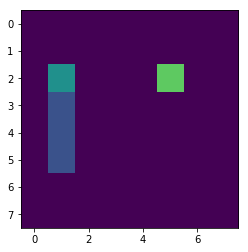

In [17]:
s = train_env.reset()
for i in range(200):
    a = a = qqtt_agent.get_q_argmax(sess, [s])[0]
    s, r, done = train_env.step(a)


    train_env.plot_state()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

    if done: break